In [1]:
import time
import random
import threading
from functools import partial

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from dmoe_emulator import EmulatedDMoE, get_non_expert_params

In [2]:
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
layer_dim = 1024
num_blocks = 4

batch_size = 4
num_trainers = 64

delay_ms = 1000

eval_interval = 1024
total_steps = eval_interval * 20
update_every_steps = 10

in_features = 28 ** 2
num_classes = 10

In [3]:
class FeedforwardBlock(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(hid_dim, 4 * hid_dim), nn.LayerNorm(4 * hid_dim), nn.ReLU(inplace=True),
            nn.Linear(4 * hid_dim, 4 * hid_dim), nn.LayerNorm(4 * hid_dim), nn.ReLU(inplace=True),
            nn.Linear(4 * hid_dim, hid_dim),
        )

    def forward(self, x):
        return x + self.layers(x)
    
Optimizer=partial(torch.optim.Adam, lr=1e-3, amsgrad=True)
emulate_latency = lambda: time.sleep(delay_ms / 1000. * np.random.weibull(1))

model = nn.Sequential(
    nn.Linear(in_features, layer_dim),
    *(FeedforwardBlock(layer_dim) for _ in range(num_blocks)),
    nn.LayerNorm(layer_dim), nn.Linear(layer_dim, num_classes)
).to(device)

# create optimizer for non-expert params only
non_expert_params = get_non_expert_params(model)
opt = Optimizer(non_expert_params)

# create initial gradients
model(torch.zeros(1, in_features, device=device)).sum().backward()
opt.zero_grad()


lock_model = threading.Lock()
need_to_eval = threading.Event()
train_history, val_history = [], []
progress = tqdm(total=total_steps)


  0%|          | 0/20480 [00:00<?, ?it/s]

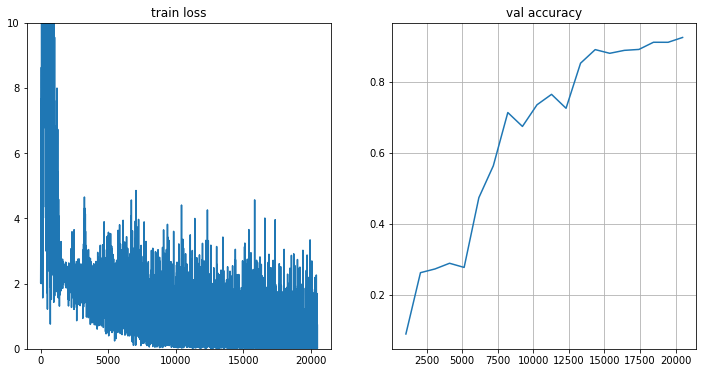

#20540	loss=0.051598	delay=50: 20540it [15:24, 19.05it/s]

In [4]:
def trainer_thread_method():
    """ train model on batches, emulate network latency """
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(lambda x: x.view(-1))
                       ])),
        batch_size=batch_size, shuffle=True,
    )

    while True:
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            with lock_model:
                model.train(True)
                initial_step_index = len(train_history)
                logits = model(xb)
                loss = F.cross_entropy(logits, yb)
                
                opt.zero_grad()
                loss.backward()
                grads = [param.grad.clone() if param.grad is not None else None
                         for param in non_expert_params]

            emulate_latency()

            with lock_model:
                model.train(True)
                opt.zero_grad()
                for param, grad in zip(non_expert_params, grads):
                    param.grad[...] = grad
                opt.step()
                train_history.append(dict(
                    loss=loss.item(), 
                    delay_steps=len(train_history) - initial_step_index,
                ))
                progress.desc = f'#{len(train_history)}\tloss={loss.item():4f}\tdelay={train_history[-1]["delay_steps"]}'
                progress.update(1)
                
                if len(train_history) % eval_interval == 0 or len(train_history) >= total_steps:
                    need_to_eval.set()
            if len(train_history) >= total_steps:
                return
                

def evaluate():
    test_loader = torch.utils.data.DataLoader(
            datasets.MNIST('../data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                transforms.Lambda(lambda x: x.view(-1))
            ])),
            batch_size=batch_size, num_workers=4, pin_memory=True,
    )
    with lock_model, torch.no_grad():
        model.train(False)
        loss_numerator = acc_numerator = denominator = 0.0
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss_numerator += F.cross_entropy(logits, yb).item() * len(yb)
            acc_numerator += (logits.argmax(-1).to(yb.dtype) == yb).to(torch.float32).sum()
            denominator += len(yb)
    return dict(loss=loss_numerator / denominator,
                acc=acc_numerator / denominator,
                num_updates=len(train_history))
            

# finally, run training
trainers = [threading.Thread(target=trainer_thread_method) for i in range(num_trainers)]
for trainer in trainers:
    trainer.start()
    
while len(train_history) < total_steps:
    need_to_eval.wait(), need_to_eval.clear()
    val_metrics = evaluate()
    val_history.append(val_metrics)
        
    clear_output(True)
    plt.figure(figsize=[12, 6])
    plt.subplot(1, 2, 1); plt.title('train loss'); plt.ylim(0, 10)
    plt.plot([info['loss'] for info in train_history])
    
    
    plt.subplot(1, 2, 2); plt.title('val accuracy'); plt.grid()
    plt.plot(*zip(*((info['num_updates'], info['acc']) for info in val_history)))
    plt.show()

for trainer in trainers:
    trainer.join()

In [5]:
import os
import pickle
!mkdir -p logs

num_files = len(os.listdir('logs'))
fname = f'logs/delay{delay_ms}ms_ffn{layer_dim}_seed{seed}.pkl'
print(fname)
with open(fname, 'wb') as f_out:
    pickle.dump(dict(train_history=train_history, val_history=val_history), f_out)

logs/delay1000ms_ffn1024_seed1337.pkl


#20543	loss=0.018364	delay=72: 20543it [15:40, 19.05it/s]